In [2]:
import pickle
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from sklearn.metrics import hamming_loss, accuracy_score
from collections import defaultdict
from scipy.linalg import subspace_angles

### Load consolidated decoding dataframe

In [3]:
decoding_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/decoding_FOB_final_analysis_230322_214006_Jamie/decoding_FOB_final_analysis_230322_214006_Jamie_glom.pickle'
with open(decoding_glom_path, 'rb') as f:
    dat_decode = pickle.load(f) 

df_decode = pd.DataFrame(dat_decode)

In [4]:
# Helpful ways to index / look at the df_decode
filtered_df_decode = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == 'AM') & (df_decode['dimreduc_method'] == 'PCA') ]
df_decode.columns

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'full_arg_tuple', 'predictions',
       'loss', 'decoding_object', 'Xtrain', 'Xtest', 'Ytrain', 'Ytest',
       'decoder', 'decoder_args', 'thresholds', 'data_file', 'loader',
       'loader_args', 'task_args', 'data_path', 'results_file'],
      dtype='object')

In [5]:
data_path = df_decode['data_path']

#### Load the processed data as well for other info

In [6]:
def make_hashable(obj):
    if isinstance(obj, dict):
        return tuple(sorted((key, make_hashable(value)) for key, value in obj.items()))
    elif isinstance(obj, (list, tuple)):
        return tuple(make_hashable(item) for item in obj)
    else:
        return obj


unique_hashes = set(make_hashable(d) for d in df_decode['full_arg_tuple'])
unique_dicts = [dict(u) for u in unique_hashes]

In [7]:
preload_dict_path = df_decode['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)


for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)

AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)

In [8]:
AM_loaded_data["StimulusNames"]

['Faces_face1.bmp',
 'Faces_face2.bmp',
 'Faces_face3.bmp',
 'Faces_face4.bmp',
 'Faces_face5.bmp',
 'Faces_face6.bmp',
 'Faces_face7.bmp',
 'Faces_face8.bmp',
 'Faces_face9.bmp',
 'Faces_face10.bmp',
 'Faces_face11.bmp',
 'Faces_face12.bmp',
 'Faces_face13.bmp',
 'Faces_face14.bmp',
 'Faces_face15.bmp',
 'Faces_face16.bmp',
 'Bodies_body1.bmp',
 'Bodies_body2.bmp',
 'Bodies_body3.bmp',
 'Bodies_body4.bmp',
 'Bodies_body5.bmp',
 'Bodies_body6.bmp',
 'Bodies_body7.bmp',
 'Bodies_body8.bmp',
 'Bodies_body9.bmp',
 'Bodies_body10.bmp',
 'Bodies_body11.bmp',
 'Bodies_body12.bmp',
 'Bodies_body13.bmp',
 'Bodies_body14.bmp',
 'Bodies_body15.bmp',
 'Bodies_body16.bmp',
 'Fruits_fruit1.bmp',
 'Fruits_fruit2.bmp',
 'Fruits_fruit3.bmp',
 'Fruits_fruit4.bmp',
 'Fruits_fruit5.bmp',
 'Fruits_fruit6.bmp',
 'Fruits_fruit7.bmp',
 'Fruits_fruit8.bmp',
 'Fruits_fruit9.bmp',
 'Fruits_fruit10.bmp',
 'Fruits_fruit11.bmp',
 'Fruits_fruit12.bmp',
 'Fruits_fruit13.bmp',
 'Fruits_fruit14.bmp',
 'Fruits_fruit15.

### Extract useful params and get average classification error 

In [9]:
degradedIDs = AM_loaded_data['degradedIDs']
dimensions = np.unique(df_decode['dim'])
n_folds = np.unique(df_decode['fold_idx'])
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_decode['dimreduc_method'])
stimIDs = AM_loaded_data['StimIDs']
numStims = len(np.unique(stimIDs))

In [10]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
all_losses = recursive_defaultdict()
 
for dr_method in dimreduc_methods:
    for reg in regions:
        all_losses[dr_method][reg] = np.zeros(len(dimensions))
        for idx, dim in enumerate(dimensions):

            df_decode_filt = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim)]
            avg_loss = np.mean(df_decode_filt['loss']) # averages loss over k_fold splits
            all_losses[dr_method][reg][idx] = avg_loss

## Average classification accuracy in subspaces

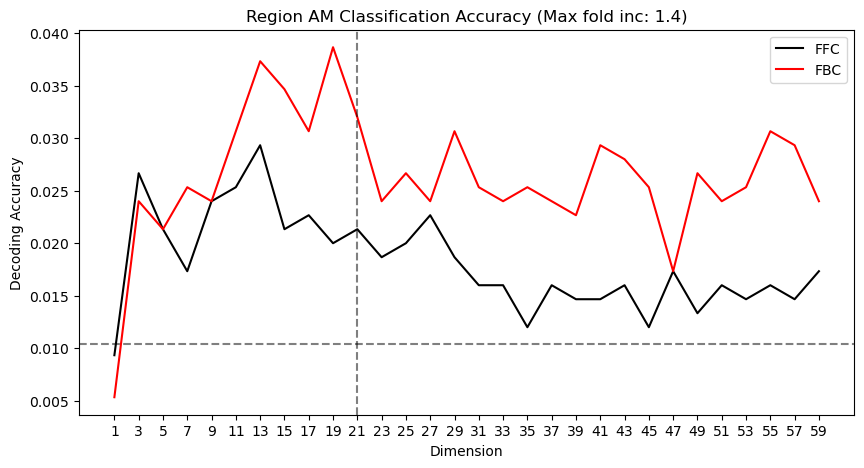

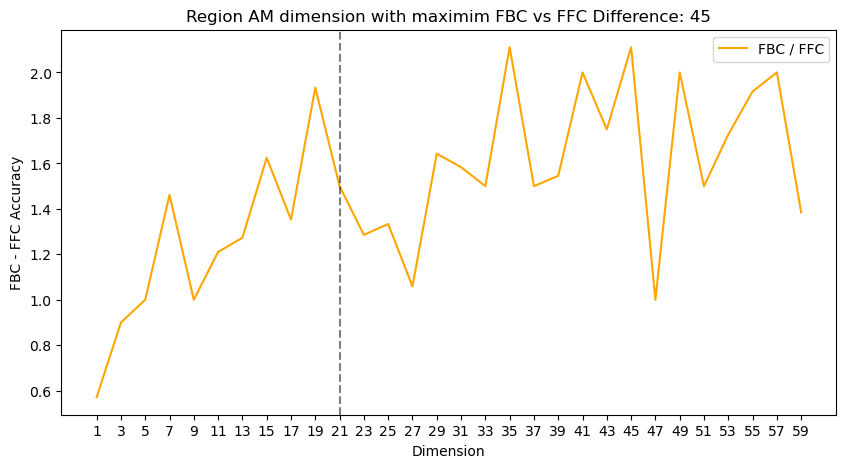

Max fold difference: 2.1111111111111183


In [13]:
region = 'AM'
plot_dims = 21

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
Diff_losses = FBC_losses / FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} Classification Accuracy (Max fold inc: {Diff_losses[dimensions == 17][0]:.1f})')

plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Decoding Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=plot_dims, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axhline(y=1/numStims, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()



plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC / FFC", color='orange')

plt.legend()
plt.title(f'Region {region} dimension with maximim FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=plot_dims, color=[0, 0, 0, 0.5], linestyle='--') 

plt.show()

print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")

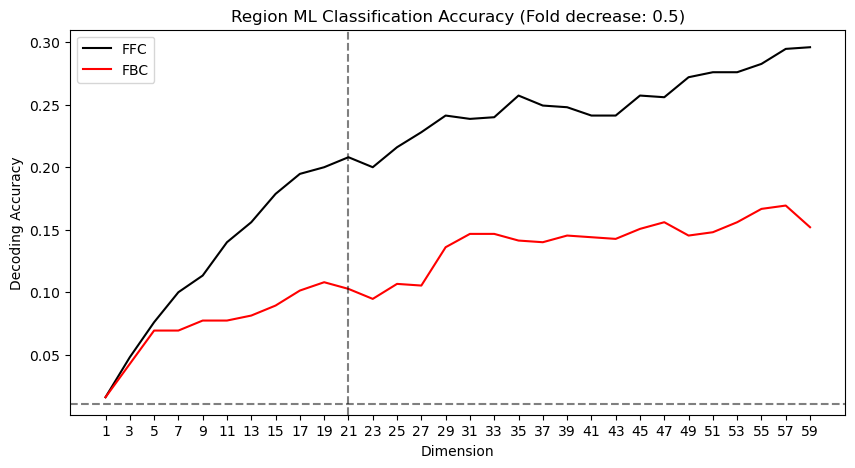

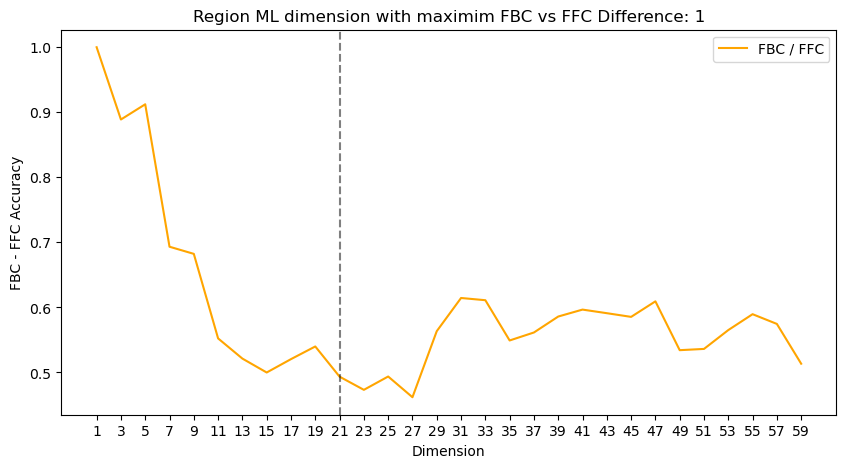

Max fold difference: 1.0


In [14]:
region = 'ML'
plot_dims = 21

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]
Diff_losses = FBC_losses / FFC_losses
max_dim_ind = np.argmax(Diff_losses)
max_diff_dim = dimensions[max_dim_ind]


plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, FFC_losses, label="FFC", color='black')
plt.plot(dimensions, FBC_losses, label="FBC", color='red')

plt.legend()
plt.title(f'Region {region} Classification Accuracy (Fold decrease: {Diff_losses[dimensions == 17][0]:.1f})')

plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Decoding Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=plot_dims, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axhline(y=1/numStims, color=[0, 0, 0, 0.5], linestyle='--') 
plt.show()



plt.figure(figsize=(10, 5))  # 10 inches wide by 5 inches tall
plt.plot(dimensions, Diff_losses, label="FBC / FFC", color='orange')

plt.legend()
plt.title(f'Region {region} dimension with maximim FBC vs FFC Difference: {max_diff_dim}')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('FBC - FFC Accuracy')
#plt.axvline(x=max_diff_dim, color=[0, 0, 0, 0.5], linestyle='--') 
plt.axvline(x=plot_dims, color=[0, 0, 0, 0.5], linestyle='--') 

plt.show()

print(f"Max fold difference: {FBC_losses[max_dim_ind]/FFC_losses[max_dim_ind]}")
